<h1 style="color:violet; text-align:center;">Assignment #5</h1>
<h3 style="color:violet; text-align:center;">Shahar Dekel 318864436</h3>
<h3 style="color:violet; text-align:center;">Amit Feiner 316552710</h3>

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import seaborn as sns
from math import log
from scipy.stats import beta 
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS, RegressionResults
from statsmodels.discrete.discrete_model import Logit
from scipy.special import logit
import scipy
import warnings
warnings.filterwarnings('ignore')

<h3>Load the dataset</h3>

In [2]:
dataset='framingham_heart_disease.csv'
df=pd.read_csv(dataset, sep=',')
df.columns.values
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


<h2>Part 1: Bayesian Approach</h2>
<h3>1.</h3>
<h3>Our Test Question from assignment #2</h3>
<br>
    Are the values of 'heartRate' different between different levels of 'currentSmoker'?


In [3]:
# Sample for the observed data
obs_samples = df[["heartRate", "currentSmoker"]].sample(200, random_state=0)

# drop records with missing values
obs_samples.dropna(inplace=True)
n_obs = obs_samples.shape[0]
print("Number of records:", n_obs)
obs_samples

Number of records: 200


,heartRate,currentSmoker
1669,75.0,0
156,60.0,0
87,57.0,1
685,100.0,0
666,65.0,0
...,...,...
1185,75.0,0
3905,80.0,0
3382,80.0,0
465,92.0,1


In [4]:
# sample for the past data
past_samples = df[~(df.index.isin(obs_samples.index.values))].sample(n=1000)
past_samples = past_samples[['heartRate', 'currentSmoker']]
past_samples.dropna(inplace=True)
n_past = past_samples.shape[0]
print("Number of records:", n_past)

past_samples

Number of records: 1000


,heartRate,currentSmoker
627,72.0,1
792,88.0,1
699,90.0,0
2371,82.0,0
2307,68.0,1
...,...,...
1628,90.0,1
182,96.0,1
1556,74.0,0
784,70.0,1


<h3>2.</h3>
We will define a new variable 𝑍 based on the variable 𝑋 ('heartRate') as follows:<br>
Select a threshold value 𝜏 so that if 𝑋>𝜏, 𝑍 = 1 and otherwise 𝑍 = 0.

In [5]:
#print("statistics for 'heartRate'",df[['heartRate']].describe(),'\n')
threshold=float(df[['heartRate']].mean())
print(threshold)

75.87892376681614


We will define the probability for variable Z:<br>
$P(Z = 1|Y = j)=p_j$        for any j=1,2

In [6]:
Z = obs_samples.apply(lambda df: 1 if df['heartRate'] > threshold else 0, axis = 1)
obs_samples = pd.concat([obs_samples, Z], axis= 1)
obs_samples = obs_samples.rename(columns={0:"Z"})
obs_samples

,heartRate,currentSmoker,Z
1669,75.0,0,0
156,60.0,0,0
87,57.0,1,0
685,100.0,0,1
666,65.0,0,0
...,...,...,...
1185,75.0,0,0
3905,80.0,0,1
3382,80.0,0,1
465,92.0,1,1


<h3>3.</h3>
We are interested on estimating $𝜓=𝜂(𝑝_1)−𝜂(𝑝_2)$<br>
First, we will preform an empirical estimation of $p_1$ and $p_2$

In [7]:
cs_true=obs_samples.where(obs_samples['currentSmoker'] == 1).count()
cs_false=obs_samples.where(obs_samples['currentSmoker'] == 0).count()

estimators={'empirical':None, 'uniform':None, 'jeffreys':None, 'past':None, 'full':None}
intervals={'empirical':None, 'uniform':None, 'jeffreys':None, 'past':None}

p1 = (obs_samples.where((obs_samples['Z'] == 1) & (obs_samples['currentSmoker'] == 1)).count()/ cs_true)[0]
p2 = (obs_samples.where((obs_samples['Z'] == 1) & (obs_samples['currentSmoker'] == 0)).count()/ cs_false)[0]

estimators['empirical']=logit(p1) - logit(p2)

print(f"p1: {p1}\n"
      f"p2: {p2}\n"
      f"Estimated 𝜓: {estimators['empirical']}")


p1: 0.4090909090909091
p2: 0.39285714285714285
Estimated 𝜓: 0.06759329113252843


In [8]:
print("A")
def bootstrap(obs_samples=obs_samples, B=400):
    estimators=list()
    data = obs_samples[['currentSmoker', 'Z']].to_numpy()
    for i in range(B):
        X = data[np.random.choice(data.shape[0], np.size(data,0), replace=True), :]
        sample = pd.DataFrame({'currentSmoker': X[:, 0], 'Z': X[:, 1]})
        cs_true=sample.where(sample['currentSmoker'] == 1).count()
        cs_false=sample.where(sample['currentSmoker'] == 0).count()
        p1 = (sample.where((sample['Z'] == 1) & (sample['currentSmoker'] == 1)).count()/ cs_true)[0]
        p2 = (sample.where((sample['Z'] == 1) & (sample['currentSmoker'] == 0)).count()/ cs_false)[0]
        
        estimators.append(logit(p1) - logit(p2))
    return np.array(estimators)

alpha=0.05
B=400
bootstrap_estimators = bootstrap()
bootstrap_estimators.sort()

intervals['empirical'] = [bootstrap_estimators[int(0.5 * alpha * B)], bootstrap_estimators[int(B - 0.5 * alpha * B)]]


print(f"Confidence Interval using bootstrap for 𝜓: {intervals['empirical']}")

A
Confidence Interval using bootstrap for 𝜓: [-0.4977403842173352, 0.6836684366054017]


We will denote:<br>
$$Z \mid Y=1 \sim Bernoulli(p_1)$$
$$Z \mid Y=0 \sim Bernoulli(p_2)$$
$$\pi(p_1,p_2)=1\cdot \mathbb{1}\{0\le p_1, p_2 \le 1\}$$
We saw in class that given $$S_u = \sum_{i=1}^n u_i, S_w = \sum_{j=1}^m w_j$$ 
$$p_1 \mid u^n \sim Beta(S_u + 1, n-S_u + 1)$$
$$p_2 \mid w^m \sim Beta(S_w + 1, m-S_w + 1)$$
when $u_i=(Z \mid Y=1)_i$ and $w_j=(Z \mid Y=0)_j$, and $m+n=200$

In [9]:
print("B")
def uniform_prior(obs_samples=obs_samples, B=1000):
    n = obs_samples.where(obs_samples['currentSmoker'] == 1).count()[0]
    m = obs_samples.where(obs_samples['currentSmoker'] == 0).count()[0]
    s_u = obs_samples[obs_samples['currentSmoker'] == 1]['Z'].sum()
    s_w = obs_samples[obs_samples['currentSmoker'] == 0]['Z'].sum()
    p1 = np.random.beta(s_u + 1, n - s_u + 1, B)
    p2 = np.random.beta(s_w + 1, m - s_w + 1, B)
    Eta_1 = [logit(p) for p in p1]
    Eta_2 = [logit(p) for p in p2]
    psi = [eta_1 - eta_2 for eta_1, eta_2 in zip(Eta_1, Eta_2)]
    return np.array(psi)

B = 1000
alpha = 0.05
unifrom = uniform_prior()
unifrom.sort()

estimators['uniform'] = unifrom.mean()
intervals['uniform'] = [unifrom[int(0.5 * alpha * B)], unifrom[int(B - 0.5 * alpha * B)]]

print(f"Uniform prior 𝜓 estimator: {estimators['uniform']}\n"
      f"Uniform prior Credible Interval: {intervals['uniform']}")

B
Uniform prior 𝜓 estimator: 0.0727037069366994
Uniform prior Credible Interval: [-0.4842692809425471, 0.6246407413913557]


As we saw in class, given that
    $$Z \mid Y=1 \sim Bernoulli(p_1)$$
    $$Z \mid Y=2 \sim Bernoulli(p_2)$$
we have that Jeffreys prior is:
    $$\pi(p_1) = \sqrt{I(p_1)} = \sqrt{\frac {1} {p_1\cdot (1-p_1)}}$$
    $$\pi(p_2) = \sqrt{I(p_2)} = \sqrt{\frac {1} {p_2\cdot (1-p_2)}}$$

The prior is a Beta $(\dfrac{1}{2}, \dfrac{1}{2})$ density. 

In our case, with Jeffreys prior we will get that the posterior is:
    $$p_1 \mid u^n \sim Beta(S_u + \frac{1}{2}, n - S_u + \frac{1}{2})$$
    $$p_2 \mid w^m \sim Beta(S_w + \frac{1}{2}, m - S_w + \frac{1}{2})$$


In [10]:
print("C")
def jeffreys_prior(obs_samples=obs_samples, B=1000):
    n = obs_samples.where(obs_samples['currentSmoker'] == 1).count()[0]
    m = obs_samples.where(obs_samples['currentSmoker'] == 0).count()[0]
    s_u = obs_samples[obs_samples['currentSmoker'] == 1]['Z'].sum()
    s_w = obs_samples[obs_samples['currentSmoker'] == 0]['Z'].sum()
    p1 = np.random.beta(s_u + 0.5, n - s_u + 0.5, B)
    p2 = np.random.beta(s_w + 0.5, m - s_w + 0.5, B)
    Eta_1 = [logit(p) for p in p1]
    Eta_2 = [logit(p) for p in p2]
    psi = [eta_1 - eta_2 for eta_1, eta_2 in zip(Eta_1, Eta_2)]
    return np.array(psi)

B = 1000
alpha = 0.05
jeffreys = jeffreys_prior()
jeffreys.sort()

estimators['jeffreys'] = jeffreys.mean()
intervals['jeffreys'] = [jeffreys[int(0.5 * alpha * B)], jeffreys[int(B - 0.5 * alpha * B)]]

print(f"Uniform prior 𝜓 estimator: {estimators['jeffreys']}\n"
      f"Uniform prior Credible Interval: {intervals['jeffreys']}")

C
Uniform prior 𝜓 estimator: 0.07983045928984787
Uniform prior Credible Interval: [-0.497152187479008, 0.6853803244448388]


For section D, first we will generate Z for the past samples.<br>
Then, we will calculate the prior with bootstrap estimators for $p_1$ and $p_2$ from the past data and fit a beta distribution to the result.

In [11]:
print("D")
Z = past_samples.apply(lambda df: 1 if df['heartRate'] > threshold else 0, axis = 1)
past_samples = pd.concat([past_samples, Z], axis= 1)
past_samples = past_samples.rename(columns={0:"Z"})
print(past_samples)

def prior_bootstrap_estimator(past_samples=past_samples, B=1000):
    p1_estimators, p2_estimators = list(), list()
    data = past_samples[['currentSmoker', 'Z']].to_numpy()
    for i in range(B):
        X = data[np.random.choice(data.shape[0], np.size(data,0), replace=True), :]
        sample = pd.DataFrame({'currentSmoker': X[:, 0], 'Z': X[:, 1]})
        cs_true=sample.where(sample['currentSmoker'] == 1).count()
        cs_false=sample.where(sample['currentSmoker'] == 0).count()
        p1 = (sample.where((sample['Z'] == 1) & (sample['currentSmoker'] == 1)).count()/ cs_true)[0]
        p2 = (sample.where((sample['Z'] == 1) & (sample['currentSmoker'] == 0)).count()/ cs_false)[0]
        
        p1_estimators.append(p1)
        p2_estimators.append(p2)
    return p1_estimators, p2_estimators

#fitting the Beta distribution
B = 1000
p1_estimators, p2_estimators = prior_bootstrap_estimator()
p1_alpha, p1_beta = scipy.stats.beta.fit(p1_estimators, floc=0, fscale=1)[:2]
p2_alpha, p2_beta = scipy.stats.beta.fit(p2_estimators, floc=0, fscale=1)[:2]
print(f'p1~Beta({p1_alpha.round(3)},{p1_beta.round(3)})\np2~Beta({p2_alpha.round(3)},{p2_beta.round(3)})')


#calculating the estimator and credible interval
def past_prior(obs_samples, B, p1_alpha, p1_beta, p2_alpha, p2_beta):
    n = obs_samples.where(obs_samples['currentSmoker'] == 1).count()[0]
    m = obs_samples.where(obs_samples['currentSmoker'] == 0).count()[0]
    s_u = obs_samples[obs_samples['currentSmoker'] == 1]['Z'].sum()
    s_w = obs_samples[obs_samples['currentSmoker'] == 0]['Z'].sum()
    p1 = np.random.beta(s_u + p1_alpha, n - s_u + p1_beta, B)
    p2 = np.random.beta(s_w + p2_alpha, m - s_w + p2_beta, B)
    Eta_1 = [logit(p) for p in p1]
    Eta_2 = [logit(p) for p in p2]
    psi = [eta_1 - eta_2 for eta_1, eta_2 in zip(Eta_1, Eta_2)]
    return np.array(psi)

B = 1000
alpha = 0.05
past = past_prior(obs_samples,B,p1_alpha,p1_beta,p2_alpha,p2_beta)
past.sort()

estimators['past'] = past.mean()
intervals['past'] = [past[int(0.5 * alpha * B)], past[int(B - 0.5 * alpha * B)]]

print(f"Uniform prior 𝜓 estimator: {estimators['past']}\n"
      f"Uniform prior Credible Interval: {intervals['past']}")

D
      heartRate  currentSmoker  Z
627        72.0              1  0
792        88.0              1  1
699        90.0              0  1
2371       82.0              0  1
2307       68.0              1  0
...         ...            ... ..
1628       90.0              1  1
182        96.0              1  1
1556       74.0              0  0
784        70.0              1  0
2269       63.0              0  0

[1000 rows x 3 columns]
p1~Beta(222.496,292.497)
p2~Beta(205.028,296.366)
Uniform prior 𝜓 estimator: 0.09020786650807587
Uniform prior Credible Interval: [-0.13161789291338227, 0.3151054201055059]


E


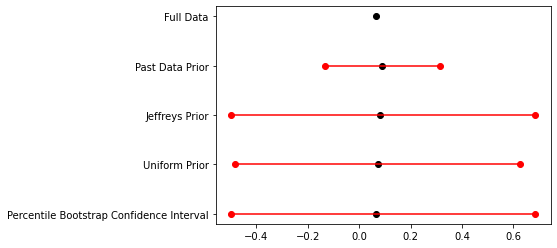

In [12]:
print("E")

# calculate for the whole data
Z = df.apply(lambda df: 1 if df['heartRate'] > threshold else 0, axis = 1)
df = pd.concat([df, Z], axis= 1)
df = df.rename(columns={0:"Z"})
#print(df)
cs_true=obs_samples.where(obs_samples['currentSmoker'] == 1).count()
cs_false=obs_samples.where(obs_samples['currentSmoker'] == 0).count()

p1 = (obs_samples.where((obs_samples['Z'] == 1) & (obs_samples['currentSmoker'] == 1)).count()/ cs_true)[0]
p2 = (obs_samples.where((obs_samples['Z'] == 1) & (obs_samples['currentSmoker'] == 0)).count()/ cs_false)[0]

estimators['full']=logit(p1) - logit(p2)


# plotting for comparison 
categories = ['Percentile Bootstrap Confidence Interval',
                         'Uniform Prior',
                         'Jeffreys Prior',
                         'Past Data Prior',
                         'Full Data']

estimator_keys=list(estimators.keys())
estimator_vals=list(estimators.values())
interval_vals=list(intervals.values())


lower_bounds, upper_bounds = zip(*interval_vals)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

for lower,upper,y in zip(lower_bounds, upper_bounds, range(len(lower_bounds))):
    plt.plot((lower,upper),(y,y),'ro-',color='red')
plt.scatter(estimator_vals, list(range(len(estimator_vals))), color='black')
plt.yticks(range(len(categories)), categories)

plt.show()

<li>
    All intervals contain the estimator calculated based on the full dataset
<li>
    We see that the bootstarp-based confidence intervals are the largest.
<li>
    The bayesian credible intervals are a bit smaller, but they are pretty similar to the bootstraping-based ones. The
    estimators are pretty close too.
<li>
    The credible interval calculated using the prior based on previous data is by far smaller than the others. 
<br><br>
    This makes a lot of sense. Using the previous data means we have prior knowledge about the data, and our "guess" of the prior is more educated - data based. When we used the uniform prior and Jeffreys prior we assumed no prior knowledge about the data, which led in turn to greater uncertainty and worse results (in comparison to the full-data estimator).

<h2>Part 2: Missing Data</h2><br>
We chose the following parameters:<br>
<li>Numeric: age, heart Rate
<li>categorial: Male (yes/no)
<li>The selected explained parameter we chose is numeric BMI<br>

<h3>1.</h3>

In [13]:
sample_all = df.copy()
sample_all.dropna(inplace=True)

samples = sample_all[["age","heartRate", "BMI","male"]].sample(1000, random_state=0)
samples

,age,heartRate,BMI,male
2013,52,50.0,24.47,1
3000,44,72.0,23.23,1
1151,38,75.0,33.49,0
3853,55,58.0,32.27,0
2453,58,71.0,23.97,1
...,...,...,...,...
3570,62,80.0,26.21,0
380,55,85.0,31.35,0
2735,41,80.0,31.12,1
978,57,92.0,24.07,1


<h3>2.</h3>

In [14]:
def beta_estimators(data):
    data.loc[data['male'] == 'female' , 'male'] = 1
    data.loc[data['male'] == 'male' , 'male'] = 0
    att = ['intercept', "age",'heartRate', 'male']
    Y = data["BMI"].to_numpy().reshape((-1,1))
    X = data[["age",'heartRate', 'male']]
    X['intercept']=1
    X= X[att]
    X = X.to_numpy(dtype='float64')

    results = OLS(Y, X).fit() 

    betas = np.array(results.params).reshape((1,-1))
    return results, pd.DataFrame(betas, columns=att, index=["Beta Estimator"])
    
results0, estimators0 = beta_estimators(samples)
estimators0.index = (['Q2 Beta Estimator'])
estimators0

,intercept,age,heartRate,male
Q2 Beta Estimator,21.163038,0.057846,0.018113,0.535418


In [15]:
def get_confidence(results):
    conf_int = pd.DataFrame(results.conf_int()[1:])
    conf_int.columns = ['Lower','Upper']
    conf_int.rename(index={0:'Age',1:'HeartRate', 2:'Male'}, inplace=True)
    return conf_int

conf_int0 = get_confidence(results0)
conf_int0

,Lower,Upper
Age,0.029662,0.086029
HeartRate,-0.002274,0.038499
Male,0.055298,1.015538


<h3>3.</h3>
We want to delete about 500 of the values of 𝑌 so that the larger the 𝑌, the greater its chance of being deleted.

In [16]:
np.random.seed(0)

samples.sort_values(by='BMI', inplace=True)
samples.reset_index(inplace=True, drop=True)
indices_missing = [index for index,p_val in enumerate(np.linspace(1/5,4/5, num=1000)) if np.random.binomial(1, p_val) ]
samples.loc[indices_missing,'BMI'] = None
samples

,age,heartRate,BMI,male
0,64,75.0,16.59,1
1,40,58.0,16.69,0
2,35,79.0,16.71,0
3,63,65.0,16.92,0
4,48,73.0,17.11,0
...,...,...,...,...
995,63,78.0,NaN,0
996,37,80.0,NaN,0
997,62,62.0,42.00,0
998,37,68.0,NaN,0


In [17]:
print(f'replacing Y -BMI values of {len(indices_missing)} none records ')

replacing Y -BMI values of 483 none records 


<h3>4.</h3>

In [18]:
print("A")
without_missing = samples.copy()
without_missing.dropna(inplace=True)
results1, estimators1 = beta_estimators(without_missing)
print('betas\n',estimators1)
conf1_int = get_confidence(results1)
print('\nConfidence Intervals\n',conf1_int)

A
betas
                 intercept       age  heartRate      male
Beta Estimator     20.161  0.046349   0.019607  1.087898

Confidence Intervals
               Lower     Upper
Age        0.012944  0.079755
HeartRate -0.006176  0.045390
Male       0.503181  1.672615


In [19]:
print("B")
with_missing = samples[samples['BMI'].isnull()]
att = ['intercept', "age",'heartRate', 'male']

X = with_missing[["age",'heartRate', 'male']]
X['intercept']=1
X= X[att]
X = X.to_numpy(dtype='float64')
prediction1 = results1.predict(X)
samples.loc[indices_missing,'BMI']=prediction1
results2, estimators2 = beta_estimators(samples)
estimators2

B


,intercept,age,heartRate,male
Beta Estimator,20.161,0.046349,0.019607,1.087898


In [20]:
conf2_int = get_confidence(results2)
conf2_int

,Lower,Upper
Age,0.028745,0.063954
HeartRate,0.006873,0.032342
Male,0.787992,1.387804


In [21]:
estimation_both=pd.concat([estimators1,estimators2])
estimation_both.index=(['based Estimators complete','based Estimators reg imp'])
estimation_both

,intercept,age,heartRate,male
based Estimators complete,20.161,0.046349,0.019607,1.087898
based Estimators reg imp,20.161,0.046349,0.019607,1.087898


In [22]:
both_ci=pd.concat([conf1_int,conf2_int],axis=1)
both_ci.columns=['complete Lower bound', 'complete Upper bound', 'reg imp Lower bound', 'reg imp Upper bound']
both_ci = both_ci[['complete Lower bound','reg imp Lower bound', 'complete Upper bound', 'reg imp Upper bound']]
both_ci

,complete Lower bound,reg imp Lower bound,complete Upper bound,reg imp Upper bound
Age,0.012944,0.028745,0.079755,0.063954
HeartRate,-0.006176,0.006873,0.045390,0.032342
Male,0.503181,0.787992,1.672615,1.387804


In [23]:
ci1_len=conf1_int['Upper']-conf1_int['Lower']
ci2_len=conf2_int['Upper']-conf2_int['Lower']
both_lens=pd.concat([ci1_len,ci2_len],axis=1)
both_lens.columns=['CI Length of complete', 'CI Length reg imp']
both_lens

,CI Length of complete,CI Length reg imp
Age,0.066810,0.035209
HeartRate,0.051566,0.025469
Male,1.169434,0.599812


from the results above, we got the same beat est in both cases, but as exepted, the CI based on reg imp shorter from the complete data because the filling of the missing data est by reg line have more data (and no more noise) 

In [24]:
print("C")
M = 1000
np.random.seed(0)
var1 = results1.mse_total 
beta_list = np.empty((M, 4))
beta_list_v = np.empty((M, 4))
for i in range(M):
    samples.loc[indices_missing,'BMI'] = np.random.normal(prediction1, np.sqrt(var1))
    results_iter, beta_list[i] = beta_estimators(samples)
    beta_list_v[i] = np.diag(results_iter.cov_params())

mi_est_beta = beta_list.mean(axis=0)
pd.DataFrame(mi_est_beta.reshape((1,-1)), columns=att, index=["est mi beta"])

C


,intercept,age,heartRate,male
est mi beta,20.145276,0.046523,0.019828,1.07661


In [25]:
print("D")
beta_se_MI = beta_list.mean(axis=0) + ((M+1)/(M*(M-1))) * np.sum((beta_list-mi_est_beta)**2, axis=0) 
beta_se_MI = np.sqrt(beta_se_MI)
pd.DataFrame(beta_se_MI.reshape((1,-1)), columns=att, index=["MI se robins formula Beta estimator"])

D


,intercept,age,heartRate,male
MI se robins formula Beta estimator,4.540941,0.215853,0.140976,1.048586


In [26]:
mi_confidence= np.empty((4,2))
mi_confidence[:,0], mi_confidence[:,1] = mi_est_beta- 1.96*beta_se_MI, mi_est_beta + 1.96*beta_se_MI
mi_confidence = pd.DataFrame(mi_confidence[1:])
mi_confidence.columns = ['Lower','Upper']
mi_confidence.rename(index={0:'Age',1:'HeartRate', 2:'Male'}, inplace=True)
mi_confidence


,Lower,Upper
Age,-0.376548,0.469594
HeartRate,-0.256484,0.296140
Male,-0.978619,3.131839


MI se CI Beta estimator

In [27]:
print("E")
samples['no_missing'] = 1
samples.loc[indices_missing,'no_missing'] = 0
samples.loc[indices_missing,'BMI'] = None
Y = samples["no_missing"].to_numpy(dtype='float64').reshape((-1,1))
X = samples[["age", 'male', 'heartRate']]
X['intercept']=1
X= X[att]
X = X.to_numpy(dtype='float64')
res_log = Logit(Y, X).fit(disp=False)
samples['probability_of_r'] = res_log.predict(X)
samples

E


,age,heartRate,BMI,male,no_missing,probability_of_r
0,64,75.0,16.59,1,1,0.450350
1,40,58.0,16.69,0,1,0.592176
2,35,79.0,16.71,0,1,0.575661
3,63,65.0,16.92,0,1,0.500013
4,48,73.0,17.11,0,1,0.539940
...,...,...,...,...,...,...
995,63,78.0,NaN,0,0,0.478518
996,37,80.0,NaN,0,0,0.567086
997,62,62.0,42.00,0,1,0.508526
998,37,68.0,NaN,0,0,0.586469


In [28]:
no_miss = samples[samples['BMI'].notnull()] 
no_miss.reset_index(inplace=True, drop=True)
for column in ['heartRate','age', 'BMI','male']:
    no_miss[column] = no_miss[column]/np.sqrt(no_miss['probability_of_r'])
no_miss

,age,heartRate,BMI,male,no_missing,probability_of_r
0,95.368491,111.759950,24.721301,1.490133,1,0.450350
1,51.979784,75.370687,21.688565,0.000000,1,0.592176
2,46.130107,104.122241,22.023831,0.000000,1,0.575661
3,89.094288,91.922678,23.928180,0.000000,1,0.500013
4,65.323344,99.345920,23.285050,0.000000,1,0.539940
...,...,...,...,...,...,...
512,67.413089,105.332952,49.323910,1.404439,1,0.506984
513,101.973460,121.759355,54.852590,1.521992,1,0.431693
514,64.894810,141.075674,51.929956,0.000000,1,0.502453
515,96.603261,123.772928,56.422342,1.509426,1,0.438911


In [29]:
f_res, f_est = beta_estimators(no_miss)
f_est.index=(['IPW Beta Estimator'])
f_est

,intercept,age,heartRate,male
IPW Beta Estimator,21.604922,0.098494,0.044299,1.508432


In [30]:
b_bootstrap = np.zeros((400,4))
for b in range(400):
    samp_curr = samples.sample(n=1000, replace=True ,random_state=b)
    Y = samp_curr["no_missing"].to_numpy(dtype='float64').reshape((-1,1))
    X = samp_curr[["age", 'male', 'heartRate']]
    X['intercept']=1
    X= X[att]
    X = X.to_numpy(dtype='float64')
    res_log = Logit(Y, X).fit(disp=False)
    samp_curr['probability_r'] = res_log.predict(X)
    samp_curr_no_miss = samp_curr[samp_curr['BMI'].notnull()] 
    for column in ['heartRate','age', 'BMI','male']:
        samp_curr_no_miss[column] = samp_curr_no_miss[column]/np.sqrt(samp_curr_no_miss['probability_r'])
    _, b_bootstrap[b] = beta_estimators(samp_curr_no_miss)
    ci_ = np.empty((3,2))    
for index in range(3):  
    sorted_val = np.sort(b_bootstrap[:,index+1],axis=0)
    ci_[index] = sorted_val[9], sorted_val[389]
ci_ = pd.DataFrame(ci_)
ci_.columns = ['Lower','Upper']
ci_.rename(index={0:'Age',1:'HeartRate', 2:'Male'}, inplace=True)
ci_

,Lower,Upper
Age,0.027998,0.158678
HeartRate,-0.007236,0.083708
Male,0.206335,2.608050


In [31]:
print("H")
beta_est_MI = pd.DataFrame(mi_est_beta.reshape((1,-1)),columns=att, index=["est mi beat"])
estimators = pd.concat([
    estimators0,
    estimation_both,
    beta_est_MI,
    f_est])
estimators.round(3)

H


,intercept,age,heartRate,male
Q2 Beta Estimator,21.163,0.058,0.018,0.535
based Estimators complete,20.161,0.046,0.020,1.088
based Estimators reg imp,20.161,0.046,0.020,1.088
est mi beat,20.145,0.047,0.020,1.077
IPW Beta Estimator,21.605,0.098,0.044,1.508


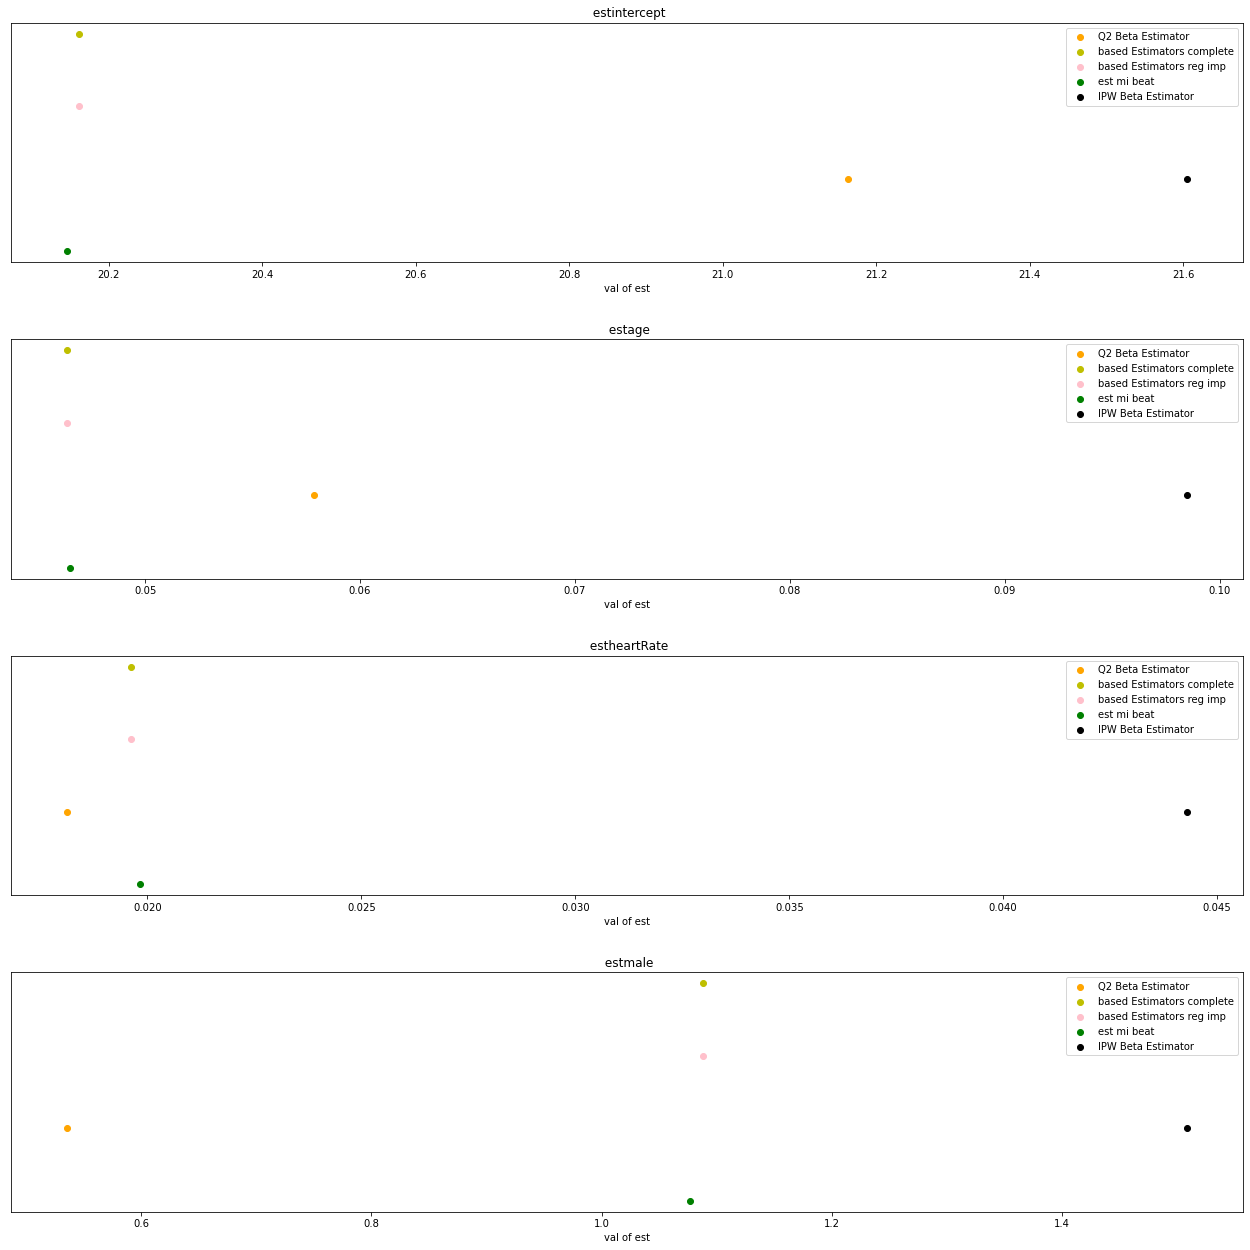

In [32]:
fig, ax = plt.subplots(4,1, figsize=(18,18))
for idx, col in enumerate(att):
    for elem, color in zip(estimators[col],['orange','y','pink','g','black']):
        if color == 'y':
            ax[idx].scatter(elem,[1.1],c=color)
        elif color == 'pink':
            ax[idx].scatter(elem,[1.05],c=color)
        elif color == 'g':
            ax[idx].scatter(elem,[0.95],c=color)
        else:
            ax[idx].scatter(elem,[1],c=color)
    ax[idx].set_title(' est' + col)
    ax[idx].set_xlabel('val of est')
    ax[idx].legend(labels=(estimators.index))
    ax[idx].set_yticks([])
fig.tight_layout(pad=3.0)

as we can see from the graphs, the multi imp est, reg imp and complete data are very similar. the reg imp and complete data are most similar and a reason for this might be as the filling of missing data is by reg line. (the mi has the same explaination).
we can also see that the ipw est is less similar maybe because the deffer calc - larger training weight so the est is more noisy to outliers.



In [33]:
full_df = sample_all[["heartRate","age", "BMI", "male"]]
_, est_df = beta_estimators(full_df)
est_df.index = (['beta est of full data'])
est_df.columns = (['intercept','Age','HeartRate','Male'])
estimators_ci = pd.concat([conf_int0,conf1_int,conf2_int,mi_confidence,ci_])

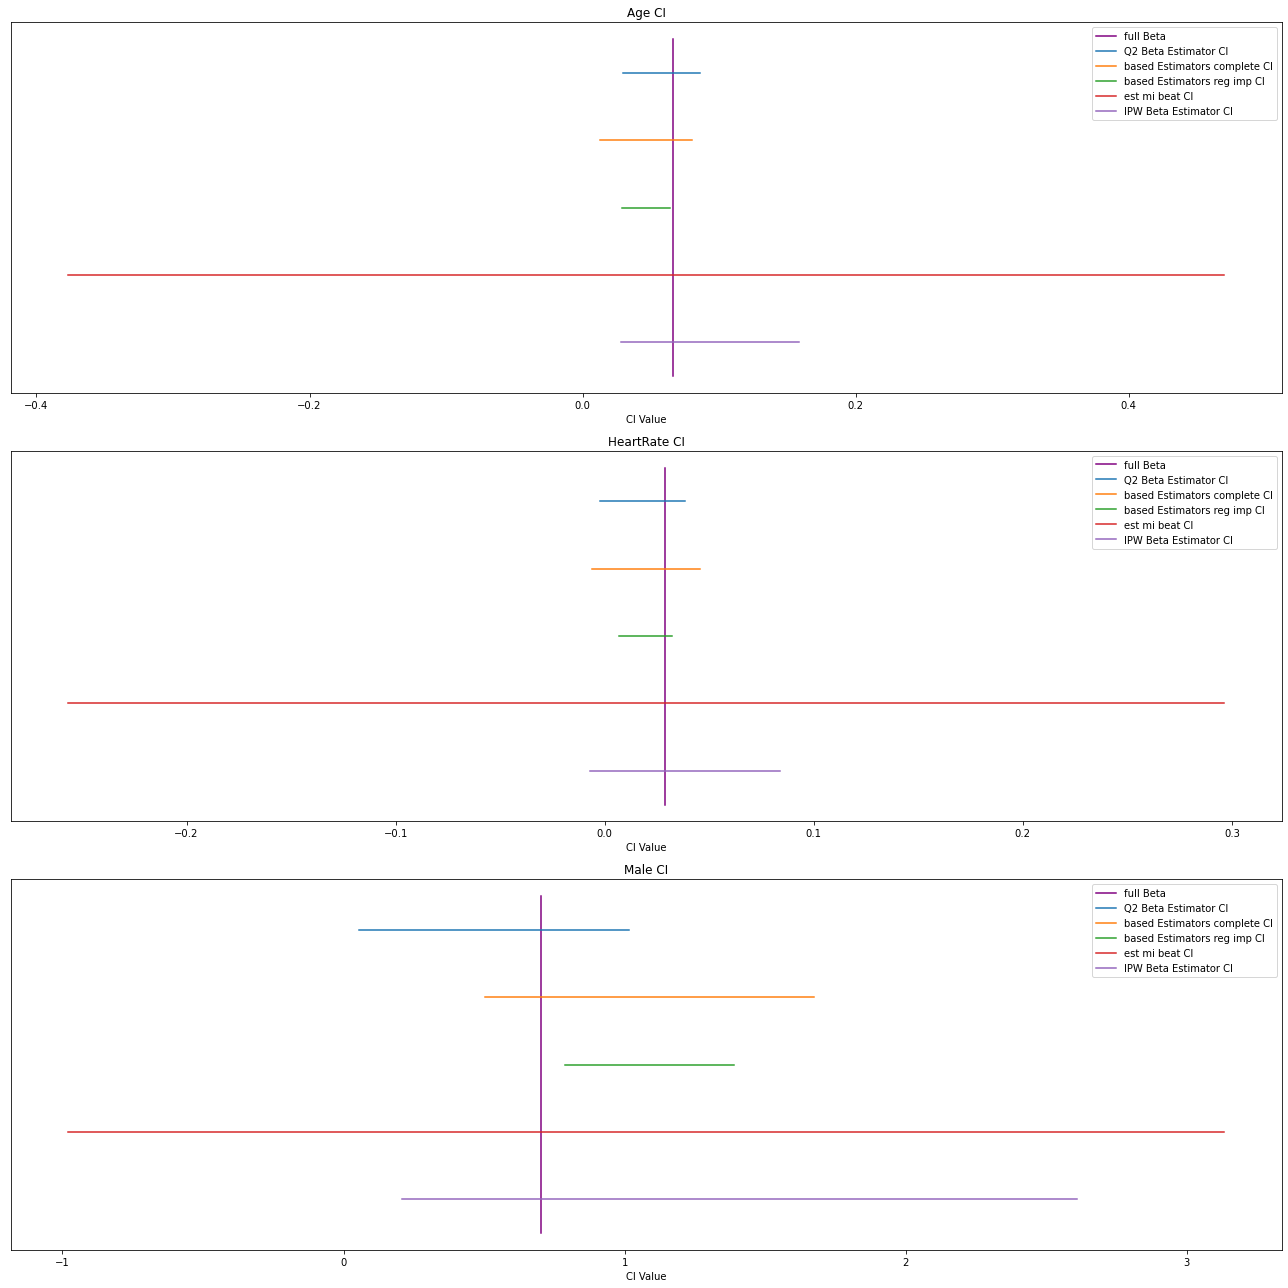

In [34]:
fig, axs = plt.subplots(3,1,figsize = (18,18))
indices=['Age','HeartRate', 'Male']
[col]
for inx,index in enumerate(indices):
    axs[inx].plot([est_df[index],est_df[index]],[0.9,1.9], color='purple', label='full Beta')
    axs[inx].plot([conf_int0.loc[index,'Lower'], conf_int0.loc[index,'Upper']], [1.8,1.8], label=estimators.index[0]+' CI')
    axs[inx].plot([conf1_int.loc[index,'Lower'], conf1_int.loc[index,'Upper']], [1.6,1.6],  label=estimators.index[1]+' CI')
    axs[inx].plot([conf2_int.loc[index,'Lower'], conf2_int.loc[index,'Upper']], [1.4,1.4], label=estimators.index[2]+' CI')
    axs[inx].plot([mi_confidence.loc[index,'Lower'], mi_confidence.loc[index,'Upper']], [1.2,1.2], label=estimators.index[3]+' CI')
    axs[inx].plot([ci_.loc[index,'Lower'], ci_.loc[index,'Upper']], [1,1], label=estimators.index[4]+' CI')
    axs[inx].set_xlabel("CI Value")
    axs[inx].set_yticks([])
    axs[inx].set_title(index + " CI")
    axs[inx].legend()
fig.tight_layout()

In [35]:
for index in indices:
    print(f'beta est ci len is {index}:')
    print(f"{estimators.index[0]}: {round(-conf_int0.loc[index,'Lower']+ conf_int0.loc[index,'Upper'],3)}")
    print(f"{estimators.index[1]}: {round(-conf1_int.loc[index,'Lower']+ conf1_int.loc[index,'Upper'],3)}")
    print(f"{estimators.index[2]}: {round(-conf2_int.loc[index,'Lower']+ conf2_int.loc[index,'Upper'],3)}")
    print(f"{estimators.index[3]}: {round(-mi_confidence.loc[index,'Lower']+ mi_confidence.loc[index,'Upper'],3)}")
    print(f"{estimators.index[4]}: {round(-ci_.loc[index,'Lower']+ ci_.loc[index,'Upper'],3)}\n")

beta est ci len is Age:
Q2 Beta Estimator: 0.056
based Estimators complete: 0.067
based Estimators reg imp: 0.035
est mi beat: 0.846
IPW Beta Estimator: 0.131

beta est ci len is HeartRate:
Q2 Beta Estimator: 0.041
based Estimators complete: 0.052
based Estimators reg imp: 0.025
est mi beat: 0.553
IPW Beta Estimator: 0.091

beta est ci len is Male:
Q2 Beta Estimator: 0.96
based Estimators complete: 1.169
based Estimators reg imp: 0.6
est mi beat: 4.11
IPW Beta Estimator: 2.402



we can see from the graphs the ci's differences of heart rate, male and age
the reg imp gave shorter ci as exepted
the ci's param contained at age and heart rate and for male but containd the reg imp only for heart rate
the ipw ci's wider in age and heart rate as exepted as well because of the ipw noiser est